In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.shape

(257777, 30)

In [3]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','issue_d','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

def transform_emp_length(emp_length):
    if emp_length in ["< 1 year", "1 year"]:
        return "0-1 year"
    elif emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "2-5 years"
    elif emp_length in ["6 years", "7 years", "8 years", "9 years", "10 years"]:
        return "6-10 years"
    elif emp_length == "10+ years":
        return "> 10 years"
    
X['emp_length'] = X['emp_length'].apply(transform_emp_length)

In [4]:
X.shape

(257777, 18)

In [5]:
X.head()

,delinq_2yrs,dti,emp_length,funded_amnt,home_ownership,inq_last_6mths,installment,loan_amnt,mths_since_last_delinq,pub_rec,purpose,term,total_acc,total_pymnt,acc_now_delinq,log_annual_inc,Effective Federal Funds Rate,state_unemployment
0,0.0,27.65,> 10 years,5000,RENT,1.0,162.87,5000,0.0,0.0,credit_card,36 months,9.0,5861.071414,0.0,10.085809,0.07,8.8
1,0.0,1.00,0-1 year,2500,RENT,5.0,59.83,2500,0.0,0.0,car,60 months,4.0,1008.710000,0.0,10.308953,0.07,9.6
2,0.0,8.72,> 10 years,2400,RENT,2.0,84.33,2400,0.0,0.0,small_business,36 months,10.0,3003.653644,0.0,9.413444,0.07,9.5
3,0.0,20.00,> 10 years,10000,RENT,1.0,339.31,10000,35.0,0.0,other,36 months,37.0,12226.302210,0.0,10.803649,0.07,11.3
4,0.0,11.20,2-5 years,5000,RENT,3.0,156.46,5000,0.0,0.0,wedding,36 months,12.0,5631.377753,0.0,10.491274,0.07,8.8


In [6]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
# dtype=int to get binary (0 or 1) values
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)

# Drop the following dummies to avoid dummy variable trap
# This ensures K-1 dummies for K groups
# Dropped dummies represent the base group
# The coefficients of the regressed dummies will be relative to the base group
X_encoded = X_encoded.drop(columns=['home_ownership_MORTGAGE','term_ 36 months','purpose_car','emp_length_0-1 year'])

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [7]:
# Drop rows with NaN values in X_train or y_train
X_train = X_train.dropna()
# Ensure y_train matches X_train
y_train = y_train[X_train.index] 

# Drop rows with NaN values in X_train or y_train
X_test = X_test.dropna()
# Ensure y_train matches X_train
y_test = y_test[X_test.index] 

Accuracy: 0.93 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     40173
         1.0       0.86      0.80      0.83     11203

    accuracy                           0.93     51376
   macro avg       0.90      0.88      0.89     51376
weighted avg       0.93      0.93      0.93     51376



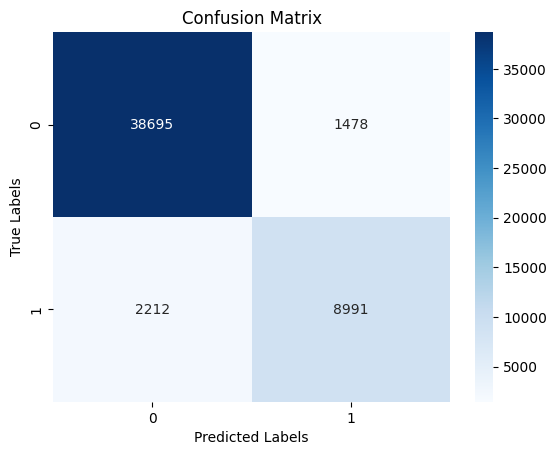

In [17]:
# Fit logistic regression model
model = LogisticRegression(solver='liblinear',max_iter=1000)
model.fit(X_train, y_train)

prob = model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (prob >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()